In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import datetime as dt
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score,accuracy_score, confusion_matrix, classification_report, plot_roc_curve,accuracy_score
import sklearn.metrics as metrics
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [64]:
data = pd.read_csv('Data.csv',encoding='cp874')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# 1.Exploratory Data Analysis

In [65]:
data.shape

(541909, 8)

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### 1.1 Missing Value

In [67]:
# Memeriksa nilai null 
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [68]:
data.isna().sum()/len(data)*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Sekitar 25% transaksi tidak mempunyai CustomerID dan sekitar 0.27% transaksi tidak memiliki deskripsi produk. Dengan mempertimbangkan banyaknya data sehingga CustomerID yang bernilai null dapat didrop

In [69]:
# Drop row yang memiliki value null di kolom CustomerID
data.dropna(subset=['CustomerID'],how='any',inplace=True)
data.shape

(406829, 8)

In [70]:
data.isna().sum()/len(data)*100

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [71]:
# Menghilangkan row yang bernilai sama
data.duplicated().sum()

5225

In [72]:
data.drop_duplicates(inplace=True)

In [73]:
data.shape

(401604, 8)

### 1.2 Explore Value

In [74]:
# Memeriksa apakah ada nilai negatif 
data.min()

InvoiceNo                              536365
StockCode                               10002
Description     4 PURPLE FLOCK DINNER CANDLES
Quantity                               -80995
InvoiceDate                   1/10/2011 10:32
UnitPrice                                   0
CustomerID                              12346
Country                             Australia
dtype: object

In [75]:
# Melakukan filter terhadap nilai negatif pada kolom Quantity
data=data[(data['Quantity']>=0)]

In [76]:
data.min()

InvoiceNo                              536365
StockCode                               10002
Description     4 PURPLE FLOCK DINNER CANDLES
Quantity                                    1
InvoiceDate                   1/10/2011 10:32
UnitPrice                                   0
CustomerID                              12346
Country                             Australia
dtype: object

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392732 non-null  object 
 1   StockCode    392732 non-null  object 
 2   Description  392732 non-null  object 
 3   Quantity     392732 non-null  int64  
 4   InvoiceDate  392732 non-null  object 
 5   UnitPrice    392732 non-null  float64
 6   CustomerID   392732 non-null  float64
 7   Country      392732 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.0+ MB


In [78]:
# Merubah kolom InvoiceDate menjadi bentuk DateTime
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])


In [79]:
data['TotalAmount']=data['Quantity']*data['UnitPrice']

In [80]:
data.shape

(392732, 9)

In [81]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# 2.Data Insight

1. InvoiceNo : Nomor pemesanan yang berisi 6 digit angka.
2. StockCode : Kode produk
3. Description : Nama produk
4. Quantity : Jumlah produk yang dibeli setiap transaksi
5. InvoiceDate : Tanggal Invoice setiap transaksi
6. UnitPrice : Harga setiap produk
7. CustomerID : Nomor ID customer yang terdiri dari 5 digit angka
8. Country : Nama negara asal customer
9. Total Amount : Total pembelian

###  2.1 Customer

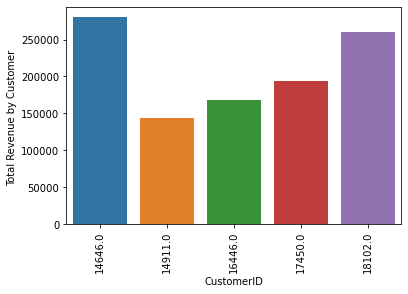

TotalAmount                       Quantity                         \
                   sum          mean  median      sum          mean   median   
CustomerID                                                                     
14646.0      280206.02    134.714433  105.60   197491     94.947596     72.0   
18102.0      259657.30    602.453132  394.80    64124    148.779582    108.0   
17450.0      194390.79    578.544018  294.48    69973    208.252976     96.0   
16446.0      168472.50  56157.500000    1.65    80997  26999.000000      1.0   
14911.0      143711.17     25.336948   17.00    80490     14.190762     10.0   
...                ...           ...     ...      ...           ...      ...   
17956.0          12.75     12.750000   12.75        1      1.000000      1.0   
16454.0           6.90      3.450000    3.45        3      1.500000      1.5   
14792.0           6.20      3.100000    3.10        2      1.000000      1.0   
16738.0           3.75      3.750000    3.75        3      3.000000      3.0   
13256.0           0.00      0.000000    0.00    12540  12540.000000  12540.0   

           UnitPrice                     
                 sum       mean  median  
CustomerID                               
14646.0      5176.09   2.488505   1.450  
18102.0      1940.92   4.503295   4.270  
17450.0      1135.32   3.378929   2.550  
16446.0         4.98   1.660000   1.650  
14911.0     26150.35   4.610428   2.100  
...              ...        ...     ...  
17956.0        12.75  12.750000  12.750  
16454.0         3.95   1.975000   1.975  
14792.0         6.20   3.100000   3.100  
16738.0         1.25   1.250000   1.250  
13256.0         0.00   0.000000   0.000  

[4339 rows x 9 columns]

In [82]:
CustomerID_Total = data.groupby('CustomerID')[['TotalAmount',
                          'Quantity',
                          'UnitPrice']].agg(['sum',
                                             'mean',
                                             'median']).sort_values(by=[('TotalAmount', 'sum')], ascending=False)
CustomerID_Total.head()

cus = data.groupby(['CustomerID'])[['TotalAmount']].sum().sort_values(by=['TotalAmount'],ascending=False).head()
sns.barplot(x=cus.index, y=cus['TotalAmount'])
plt.figsize=(2, 10)
plt.ylabel('Total Revenue by Customer ')
plt.xticks(rotation=90)
plt.show()

display(CustomerID_Total)

Customer ID 14646, 18102, 17450, 16446, 14911 merupakan 5 pelanggan yang memberikan revenue

In [83]:
data[data['CustomerID'] == 14646.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
37952,539491,21981,PACK OF 12 WOODLAND TISSUES,12,2010-12-20 10:09:00,0.29,14646.0,Netherlands,3.48
37953,539491,21986,PACK OF 12 PINK POLKADOT TISSUES,12,2010-12-20 10:09:00,0.29,14646.0,Netherlands,3.48
37954,539491,22720,SET OF 3 CAKE TINS PANTRY DESIGN,2,2010-12-20 10:09:00,4.95,14646.0,Netherlands,9.90
37955,539491,21931,JUMBO STORAGE BAG SUKI,1,2010-12-20 10:09:00,1.95,14646.0,Netherlands,1.95
37956,539491,22613,PACK OF 20 SPACEBOY NAPKINS,2,2010-12-20 10:09:00,0.85,14646.0,Netherlands,1.70
...,...,...,...,...,...,...,...,...,...
534958,581176,22908,PACK OF 20 NAPKINS RED APPLES,96,2011-12-07 15:19:00,0.72,14646.0,Netherlands,69.12
534959,581176,22907,PACK OF 20 NAPKINS PANTRY DESIGN,96,2011-12-07 15:19:00,0.72,14646.0,Netherlands,69.12
534960,581176,22029,SPACEBOY BIRTHDAY CARD,72,2011-12-07 15:19:00,0.36,14646.0,Netherlands,25.92
534961,581176,22712,CARD DOLLY GIRL,72,2011-12-07 15:19:00,0.36,14646.0,Netherlands,25.92


### 2.2 Product

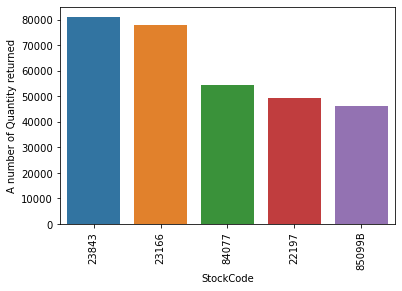

,Quantity
StockCode,
23843,80995
23166,77916
84077,54319
22197,49160
85099B,46078


,,,Quantity
StockCode,UnitPrice,Description,
23843,2.08,"PAPER CRAFT , LITTLE BIRDIE",80995
23166,1.04,MEDIUM CERAMIC TOP STORAGE JAR,76087
84077,0.29,WORLD WAR 2 GLIDERS ASSTD DESIGNS,27432


In [84]:
fav1 = data.groupby(['StockCode'])[['Quantity']].sum().sort_values(by=['Quantity'],ascending=False).head()

fav2 = data.groupby(['StockCode', 'UnitPrice','Description'])[['Quantity']].sum().sort_values(by=['Quantity'],ascending=False).head(3)

sns.barplot(x=fav1.index, y=fav1['Quantity'])
plt.ylabel('A number of Quantity returned')
plt.xticks(rotation=90)
plt.show()

display(fav1)
display(fav2)

-  StockCode 23843, 23166, dan 22197 merupakan barang terlaris yaitu PAPER CRAFT,MEDIUM CERAMIC TOP STORAGE JAR, dan WORLD WAR 2 GLIDERS ASSTD DESIGNS

### 2.3 Revenue 

In [85]:
# Merubah kolom InvoiceDate menjadi bentuk DateTime
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])

data_date=data.copy()
# Membuat features baru
data_date['date'] = data_date['InvoiceDate'].dt.date   
data_date['day'] = data_date['InvoiceDate'].dt.day
data_date['month'] = data_date['InvoiceDate'].dt.month
data_date['year'] = data_date['InvoiceDate'].dt.year
data_date['hour'] = data_date['InvoiceDate'].dt.hour
data_date['dayofweek'] = data_date['InvoiceDate'].dt.dayofweek
data_date['dayofweek'] = data_date['dayofweek'].map( {0: '1_Mon', 1: '2_Tue', 2: '3_Wed', 3: '4_Thur', 4: '5_Fri', 5: '6_Sat', 6: '7_Sun'})
data_date.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,date,day,month,year,hour,dayofweek
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,1,12,2010,8,3_Wed
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,1,12,2010,8,3_Wed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,1,12,2010,8,3_Wed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,1,12,2010,8,3_Wed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,1,12,2010,8,3_Wed


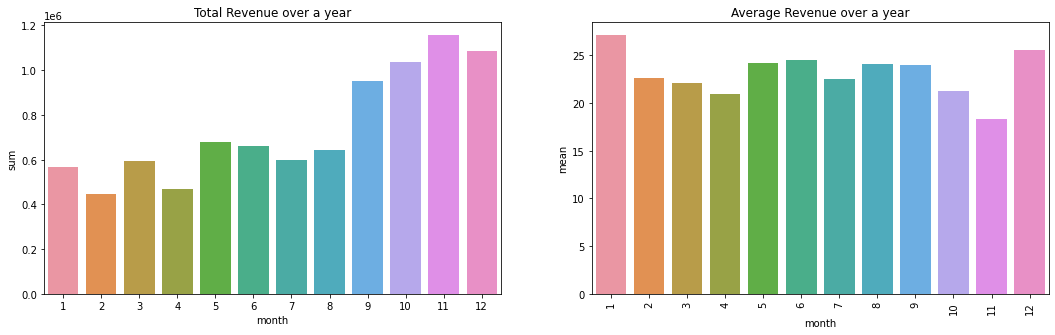

,sum,mean
month,,
1,568101.310,27.064042
2,446084.920,22.635861
3,594081.760,22.107836
4,468374.331,20.876948
5,677355.150,24.126630
6,660046.050,24.513335
7,598962.901,22.532650
8,644051.040,24.035343
9,950690.202,23.964362


In [86]:

month_sales = data_date.groupby(['month'])['TotalAmount'].agg(['sum','mean'])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

sns.barplot(x=month_sales.index, y=month_sales['sum'], ax=axes[0]).set_title("Total Revenue over a year")
plt.ylabel('a')
plt.xticks(rotation=90)

sns.barplot(x=month_sales.index, y=month_sales['mean'], ax=axes[1]).set_title("Average Revenue over a year")
plt.xticks(rotation=90)
plt.show()

month_sales

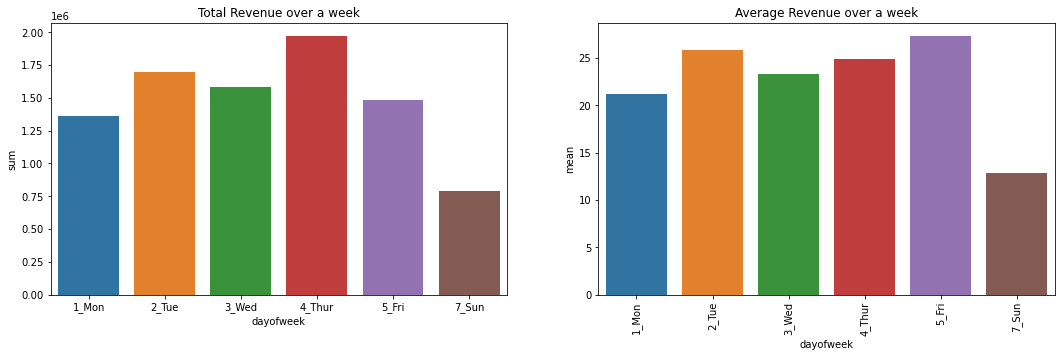

,sum,mean
dayofweek,,
1_Mon,1363604.401,21.227710
2_Tue,1697733.801,25.822225
3_Wed,1584283.830,23.283568
4_Thur,1973015.730,24.892956
5_Fri,1483080.811,27.347473
7_Sun,785490.321,12.831874


In [87]:
dayofweek_sales = data_date.groupby(['dayofweek'])['TotalAmount'].agg(['sum','mean',])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

sns.barplot(x=dayofweek_sales.index, y=dayofweek_sales['sum'], ax=axes[0]).set_title("Total Revenue over a week")
plt.ylabel('a')
plt.xticks(rotation=90)

sns.barplot(x=dayofweek_sales.index, y=dayofweek_sales['mean'], ax=axes[1]).set_title("Average Revenue over a week")
plt.xticks(rotation=90)
plt.show()

dayofweek_sales

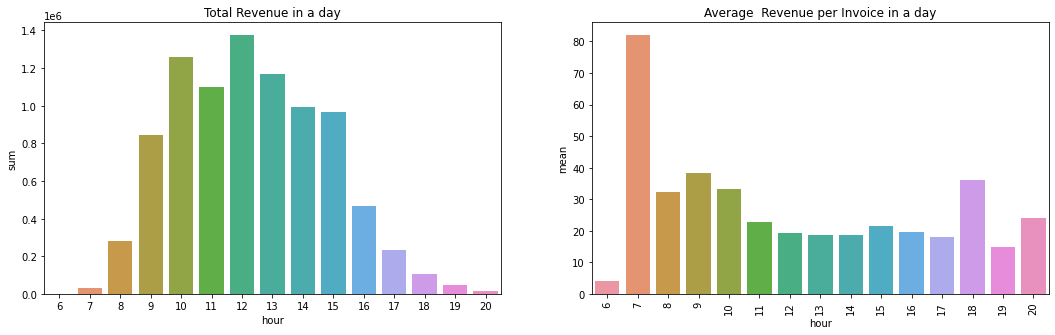

,sum,mean
hour,,
6,4.250,4.250000
7,31059.210,81.950422
8,281997.790,32.458309
9,842392.341,38.416287
10,1259267.591,33.336005
11,1101177.600,22.764302
12,1373695.390,19.363641
13,1168724.200,18.544113
14,991992.821,18.625475


In [88]:
hour_sales = data_date.groupby(['hour'])['TotalAmount'].agg(['sum','mean'])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

sns.barplot(x=hour_sales.index, y=hour_sales['sum'], ax=axes[0]).set_title("Total Revenue in a day")
plt.ylabel('a')
plt.xticks(rotation=90)

sns.barplot(x=hour_sales.index, y=hour_sales['mean'], ax=axes[1]).set_title("Average  Revenue per Invoice in a day")
plt.xticks(rotation=90)
plt.show()

hour_sales

- Dalam timeframe Bulanan, di bulan 1(Januari) hingga 8(Agustus)  memiliki peningkatan namun tidak signifikan, selama range tersebut penjualan mengalami fase sideways (naik turun). Penjualan meningkat cukup drastis pada bulan November hingga akhir tahun


- Dalam timeframe harian, penjualan di week days sideways, tidak ada penjualan pada hari sabtu, dan penjualan pada hari minggu menurun lebih dari 50%.


- Dalam timeframe 1 jam, penjualan terjadi dari pukul 7-20, busy hour terjadi pada pukul 9-15. Pada grafik Average Revenue terlihat pada pukul 7 sangat tinggi, ini menandakan orang-orang akan membeli banyak barang pada pagi hari

### 2.4 Countries 
Karena data set yang digunakan merupakan online retail yang berasal dari United Kingdom(UK), maka kita tidak ikut sertakan UK agar mendapat insgiht baru.

In [89]:
Country=data.groupby('Country')[['TotalAmount']].agg(['sum','mean', 'median']).sort_values(by=[('TotalAmount', 'sum')], ascending=False)
display(Country)
print(f"Jumlah Negara {len(Country)}")

TotalAmount                   
                               sum        mean median
Country                                              
United Kingdom        7.285025e+06   20.860428  10.20
Netherlands           2.854463e+05  120.798282  91.80
EIRE                  2.652625e+05   36.699289  17.40
Germany               2.286784e+05   25.332713  17.00
France                2.089343e+05   25.091187  16.60
Australia             1.384538e+05  116.937340  66.00
Spain                 6.155856e+04   24.822000  15.00
Switzerland           5.644395e+04   30.642752  17.70
Belgium               4.119634e+04   20.283772  16.60
Sweden                3.836783e+04   85.261844  32.25
Japan                 3.741637e+04  116.561900  70.20
Norway                3.616544e+04   33.736418  19.80
Portugal              3.337584e+04   22.970296  16.50
Finland               2.254608e+04   32.913985  17.85
Singapore             2.127929e+04   95.852658  36.75
Channel Islands       2.044054e+04   27.363507  17.70
Denmark               1.895534e+04   49.882474  23.40
Italy                 1.748324e+04   23.064960  17.70
Cyprus                1.350285e+04   22.392786  16.50
Austria               1.019868e+04   25.624824  17.17
Poland                7.334650e+03   22.226212  17.40
Israel                7.215840e+03   29.452408  19.50
Greece                4.760520e+03   32.831172  16.60
Iceland               4.310000e+03   23.681319  17.00
Canada                3.666380e+03   24.280662  16.50
USA                   3.580390e+03   20.002179  16.60
Malta                 2.725590e+03   24.335625  17.20
Unspecified           2.660770e+03   11.040539   8.95
United Arab Emirates  1.902280e+03   27.974706  20.40
Lebanon               1.693880e+03   37.641778  31.60
Lithuania             1.661060e+03   47.458857  45.00
European Community    1.300250e+03   21.670833  17.70
Brazil                1.143600e+03   35.737500  19.65
RSA                   1.002310e+03   17.281207  16.50
Czech Republic        8.267400e+02   33.069600  31.20
Bahrain               5.484000e+02   32.258824  25.50
Saudi Arabia          1.459200e+02   16.213333  17.70

Jumlah Negara 37


TotalAmount                   
                    sum        mean median
Country                                   
Netherlands   285446.34  120.798282  91.80
EIRE          265262.46   36.699289  17.40
Germany       228678.40   25.332713  17.00
France        208934.31   25.091187  16.60
Australia     138453.81  116.937340  66.00
Spain          61558.56   24.822000  15.00
Switzerland    56443.95   30.642752  17.70
Belgium        41196.34   20.283772  16.60
Sweden         38367.83   85.261844  32.25

Text(0, 0.5, 'Country')

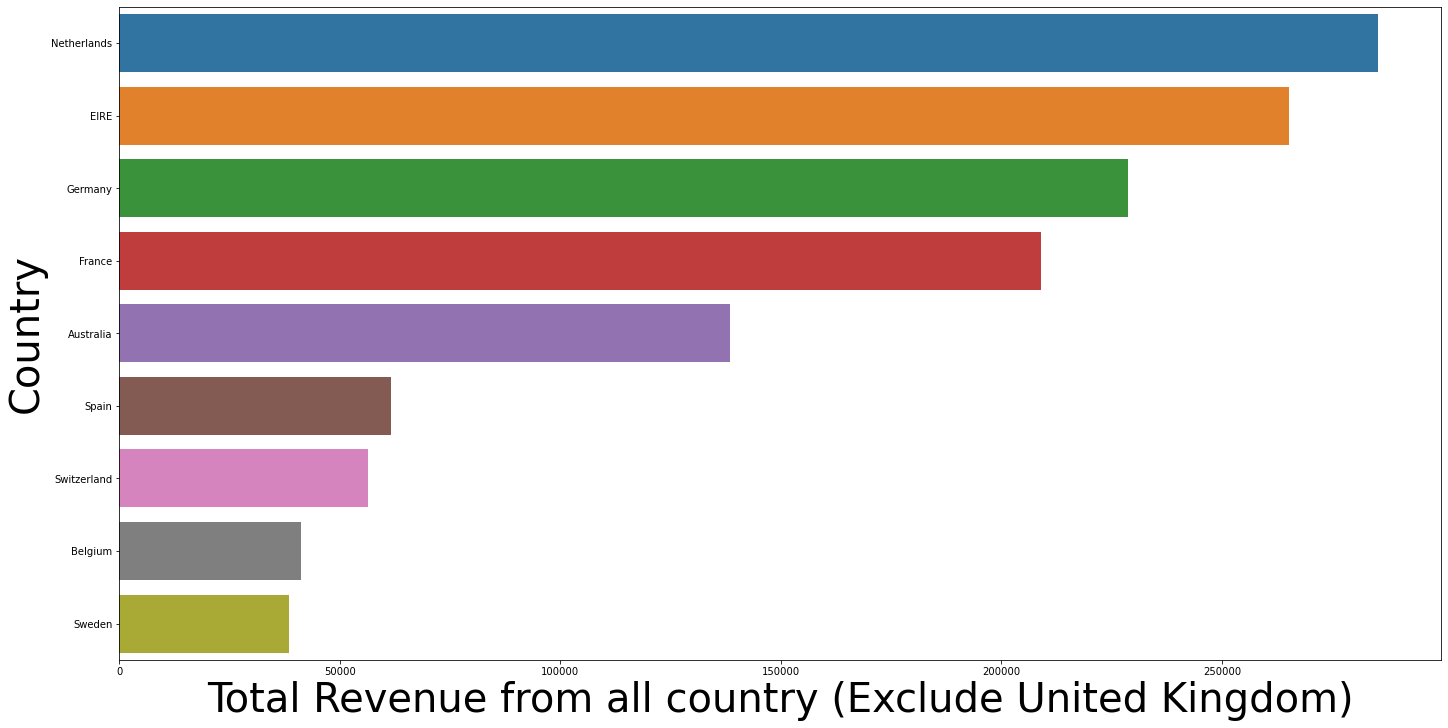

In [92]:
# Terdapat 37 negara, sehingga kita mengambil 10 ter-atas saja
# Country_UK= Country[:10].drop('United Kingdom')
display(Country_UK)
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
a = sns.barplot(y=Country_UK.index, x=Country_UK[('TotalAmount', 'sum')])
plt.xlabel('Total Revenue from all country (Exclude United Kingdom)', fontsize=40)
plt.ylabel('Country', fontsize=40)

Belanda, Irlandia, German, dan Prancis merupakan negara yang paling banyak memberikan revenue, sehingga ada potensi untuk melakukan ekspansi di ke-4 negara tersebut untuk meningkatkan revenue perusahaan.

Quantity                  
                 sum       mean median
Country                               
Netherlands   200937  85.034702     72
EIRE          140383  19.422108     12
Germany       119156  13.199956     10
France        111429  13.381650     10
Australia      84199  71.114020     32
Sweden         36078  80.173333     24
Switzerland    30083  16.331705     12
Spain          27944  11.267742      6
Japan          26016  81.046729     48

Text(0, 0.5, 'Quantity')

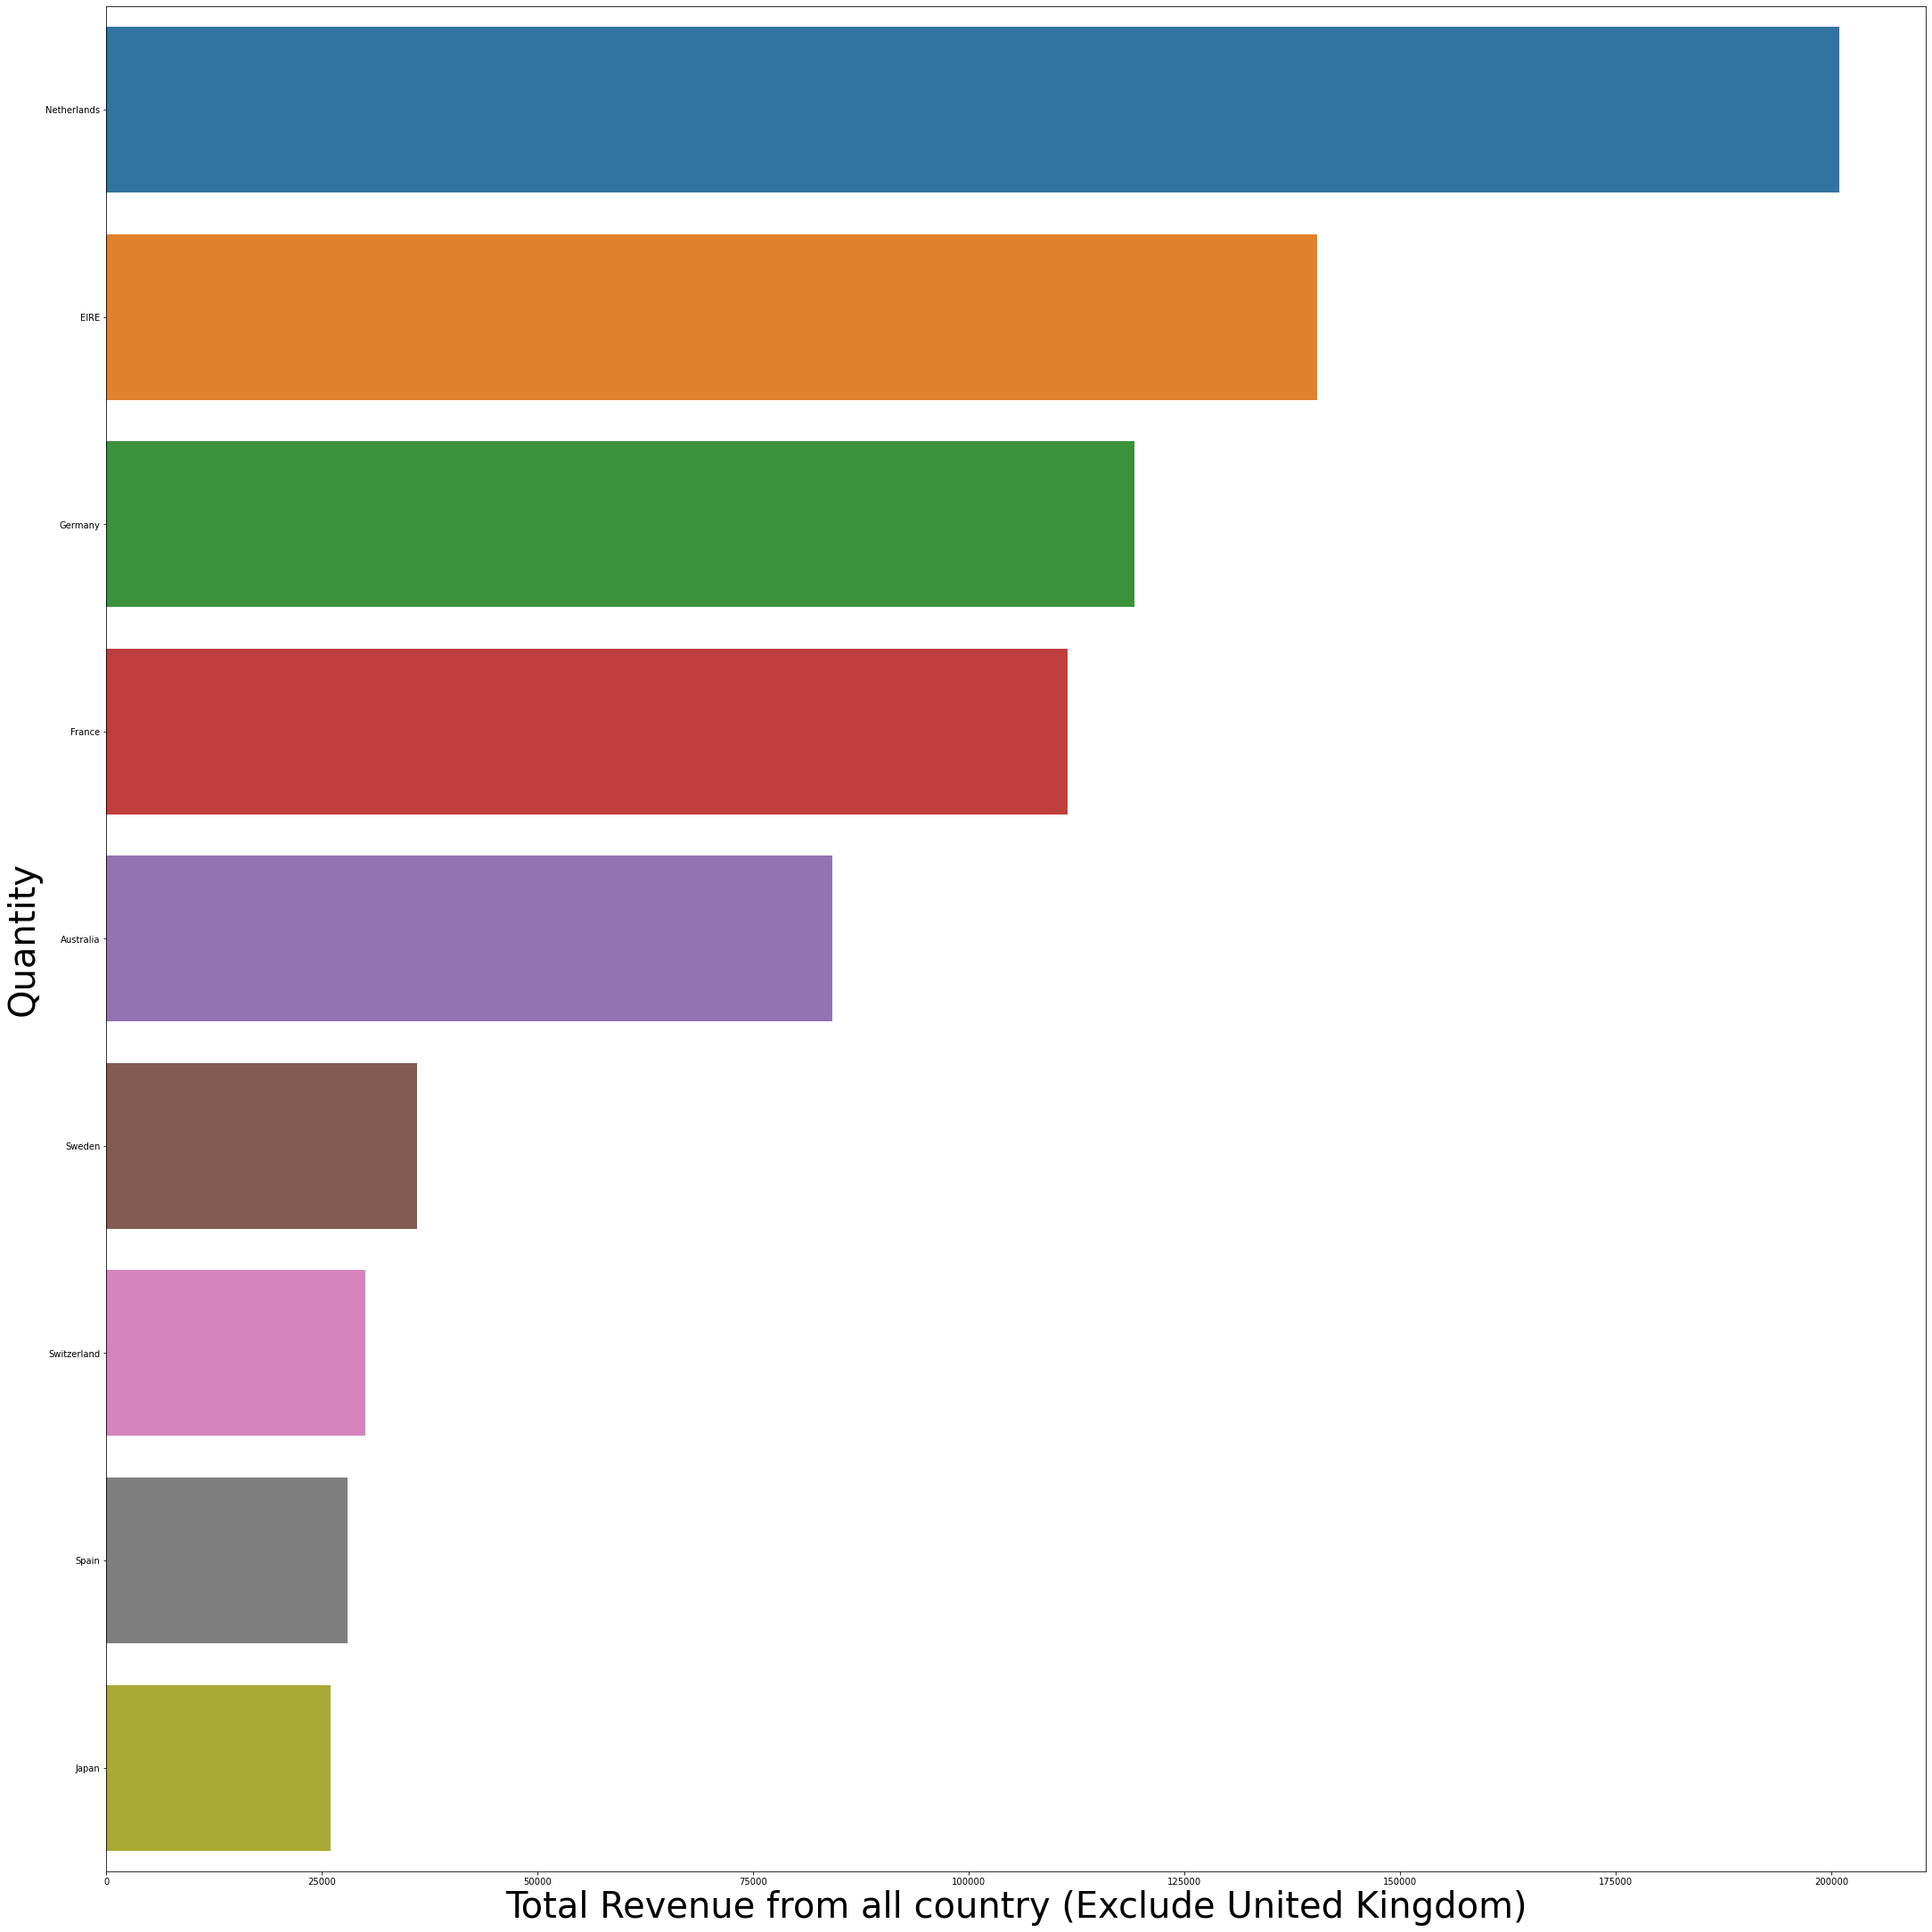

In [29]:
Country=data.groupby('Country')[['Quantity']].agg(['sum','mean', 'median']).sort_values(by=[('Quantity', 'sum')], ascending=False)
Country_UK= Country[:10].drop('United Kingdom')
display(Country_UK)
fig = plt.figure(constrained_layout=True, figsize=(30, 30))
a = sns.barplot(y=Country_UK.index, x=Country_UK[('Quantity', 'sum')])
plt.xlabel('Total Revenue from all country (Exclude United Kingdom)', fontsize=40)
plt.ylabel('Quantity', fontsize=40)

UnitPrice           
                         sum       mean
Country                                
Singapore           12949.99  58.333288
Canada                910.58   6.030331
Portugal             8636.43   5.943861
Cyprus               3466.15   5.748176
Lebanon               242.44   5.387556
Finland              3628.44   5.296993
Norway               5662.47   5.282155
Malta                 545.19   4.867768
European Community    289.80   4.830000
Italy                3576.21   4.717955

Text(0, 0.5, 'UnitePrice')

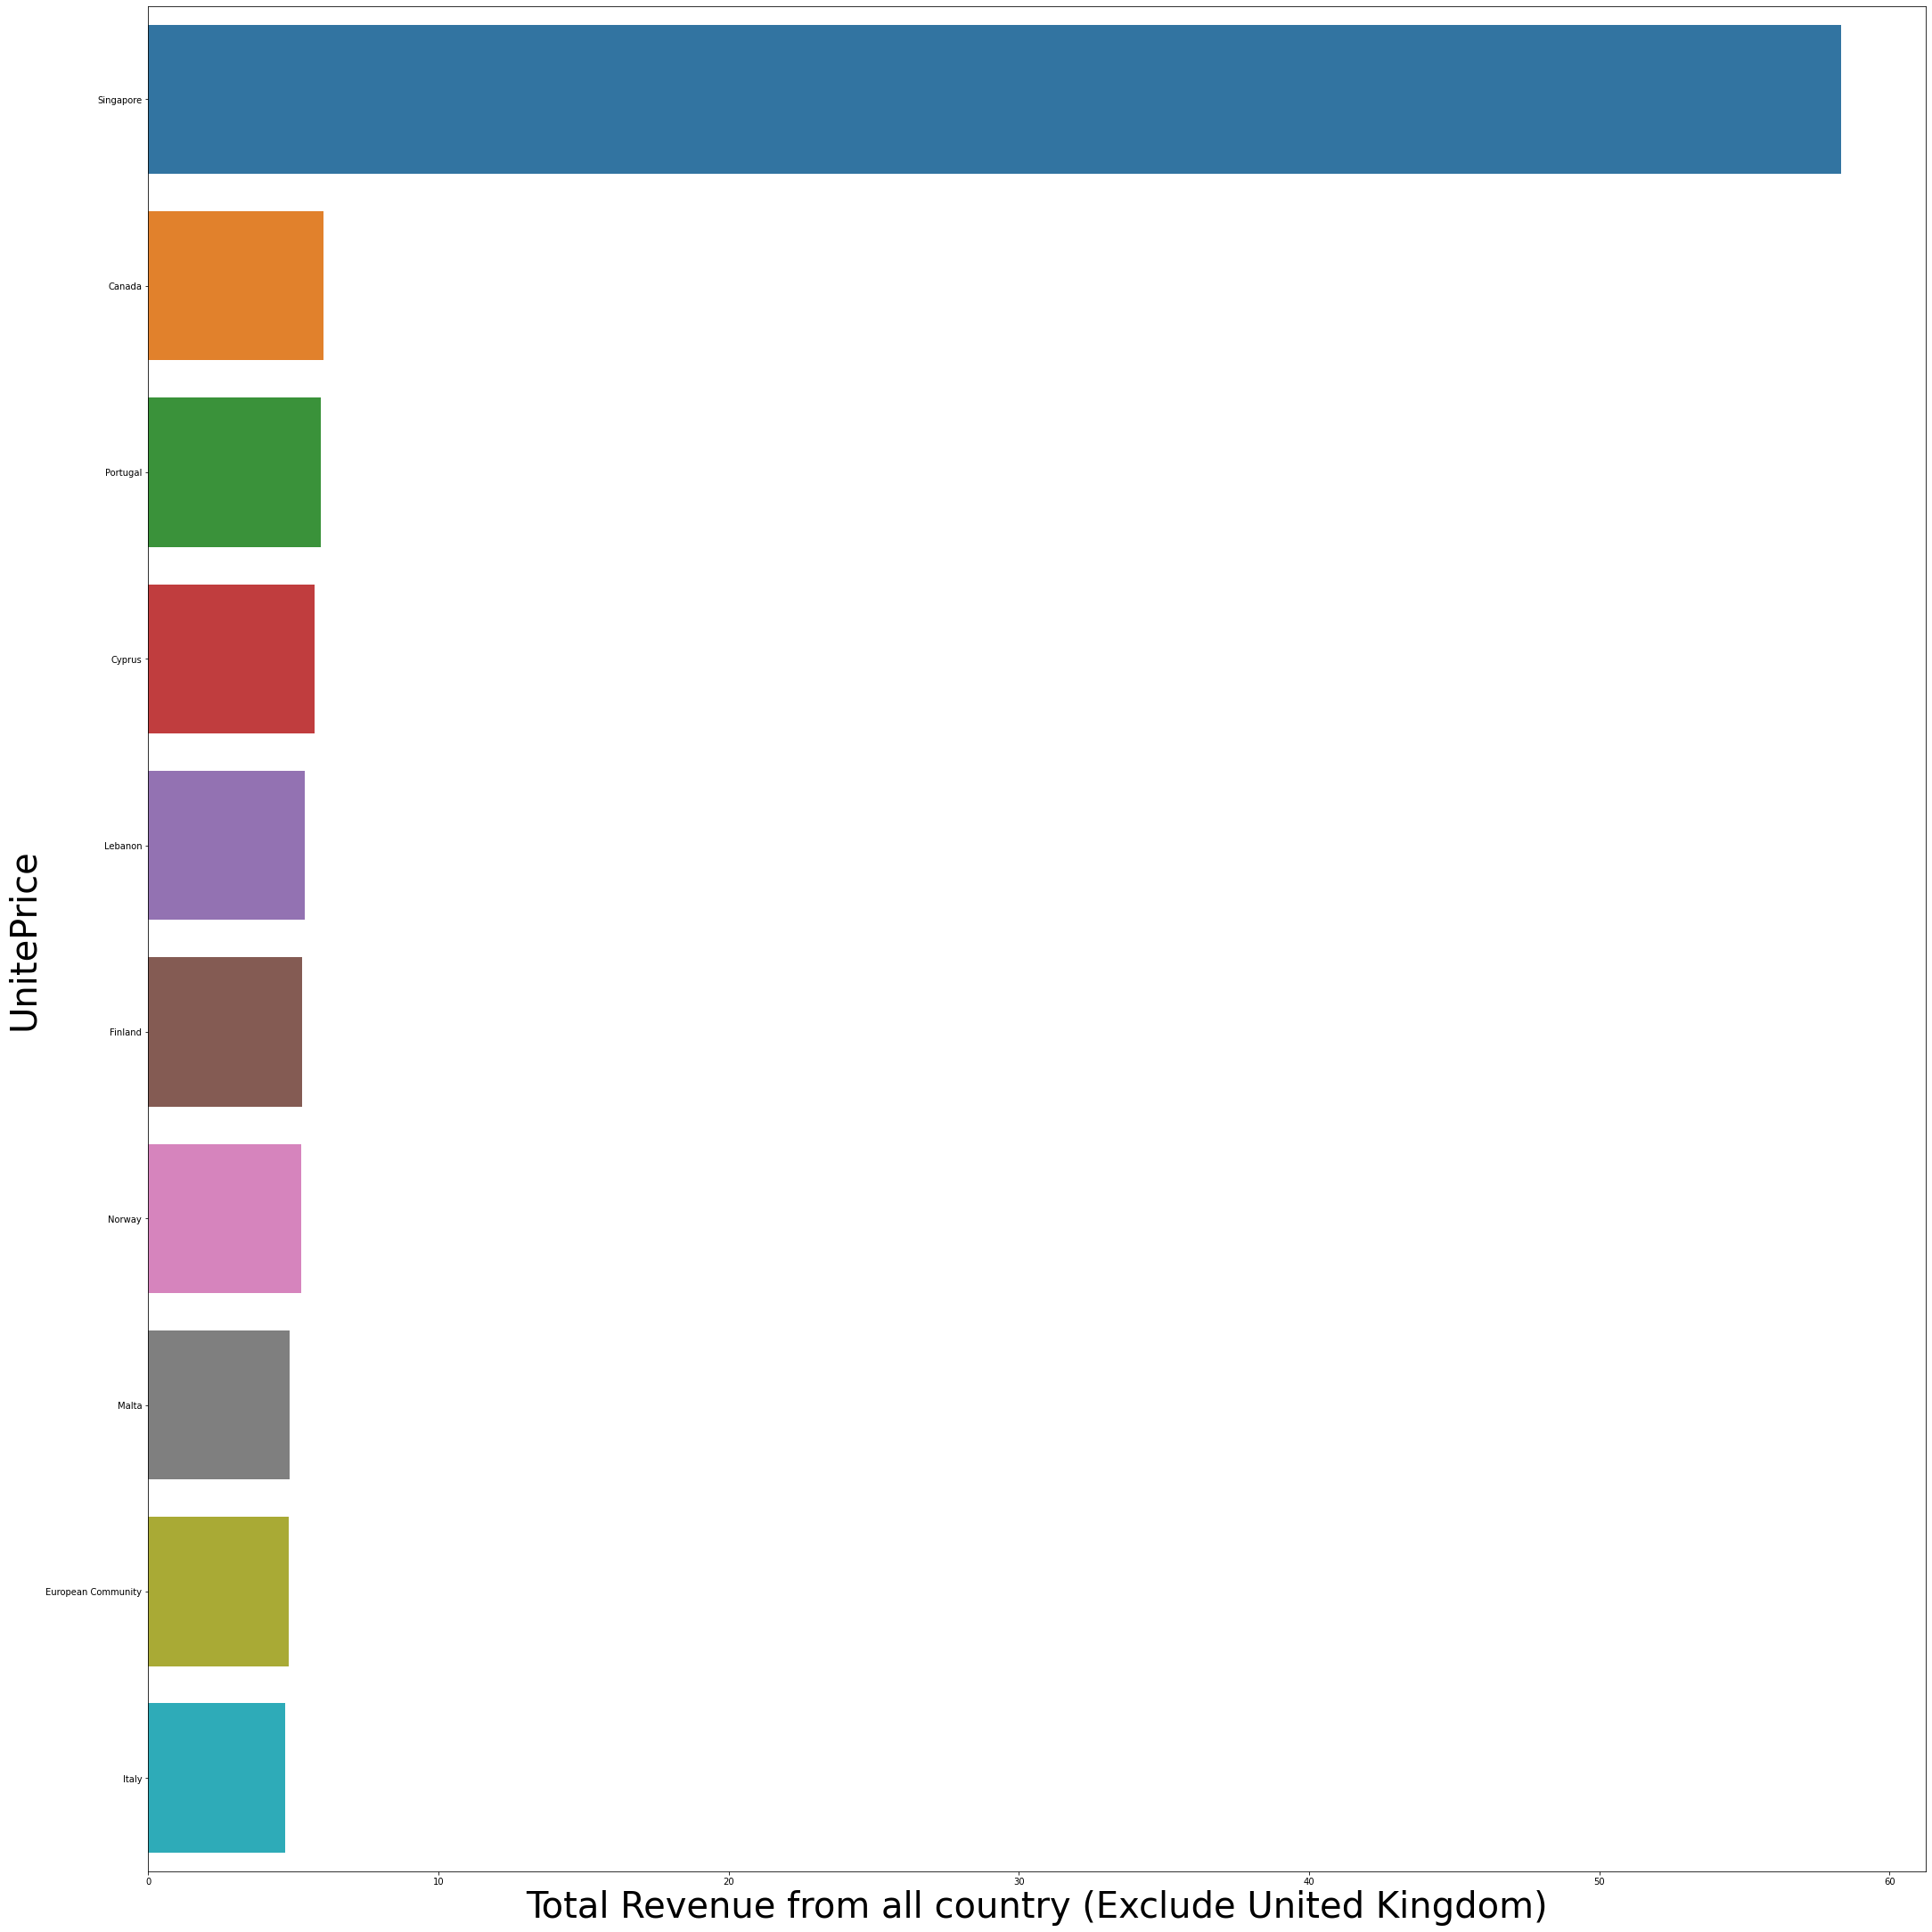

In [30]:
Country=data.groupby('Country')[['UnitPrice']].agg(['sum','mean']).sort_values(by=[('UnitPrice', 'mean')], ascending=False)
Country_UK= Country[:10]
display(Country_UK)
fig = plt.figure(constrained_layout=True, figsize=(30, 30))
a = sns.barplot(y=Country_UK.index, x=Country_UK[('UnitPrice', 'mean')])
plt.xlabel('Total Revenue from all country (Exclude United Kingdom)', fontsize=40)
plt.ylabel('UnitePrice', fontsize=40)

Singapura menjadi negara tertinggi dalam pembelian barang-barang yang memiliki harga tinggi 

# 3. RFM Analysis 
Dalam feature extraction metode yang akan digunakan adalah RFM analysis. RFM analysis adalah salah satu teknik Customer Segmentation yang digunakan untuk melihat kebiasaan ketika membeli yang dibagi menjadi beberapa tipe pembeli.
- Recency (R)   : Hari terakhir pembelian
- Frequency (F) : Total pembelian
- Monetary (M)  : Total biaya yang dihabiskan

### 3.1 RECENCY
Untuk menghitung recency, kita harus mencari tanggal terakhir dari data, kemudian dikurangi dengan tanggal pembelian

In [31]:
data['InvoiceDate'] = data['InvoiceDate'].astype('datetime64')
data['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [32]:
# Mencari patokan tanggal terakhir pada data
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [33]:
data['Date'] = data['InvoiceDate'].apply(lambda x: x.date())

In [34]:
recency = data.groupby(by='CustomerID', as_index=False)['Date'].max()
recency.columns = ['CustomerID','LastPurshaceDate']
recency.head()

,CustomerID,LastPurshaceDate
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02


In [35]:
recency['Recency'] = recency['LastPurshaceDate'].apply(lambda x: (now - x).days)
recency.head()

,CustomerID,LastPurshaceDate,Recency
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310


In [36]:
recency.drop('LastPurshaceDate',axis=1,inplace=True)
recency.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


### 3.2 Frequency
Frequency dapat dicari melalui berapa banyak pemesanan oleh nomer ID Customer yang sama, sehingga kita dapat mengetahui seberapa sering pelanggan membeli.

In [37]:
freq = data.copy()
freq.drop_duplicates(['InvoiceNo','CustomerID'],keep='first',inplace=True)
frequency = freq.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency.columns = ['CustomerID','Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


### 3.3 Monetary
Untuk mecari Monetary kita hanya perlu menjumlahkan total belanjaan kemudian dilakukan penggabungan berdasarkan Customer ID

In [38]:
monetary = data.groupby(by='CustomerID',as_index=False).agg({'TotalAmount': 'sum'})
monetary.columns = ['CustomerID','Monetary']
monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


###  3.4 RFM Table

In [39]:
rfm = recency.merge(frequency,on='CustomerID').merge(monetary,on='CustomerID')
rfm.set_index('CustomerID',inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,18,1,1757.55
12350.0,310,1,334.40


### 3.5  RFM  Score 
Untuk mendapatkan RFM Score bisa menggunakan quartil sehingga data akan terbagi menjadi 4 score dari yang terkecil 1, 2, 3, dan 4 untuk masing-masing features. Untuk mendapatkan nilai akhir dari RFM score adalah menggabungkan nilai dari tiap features. 



In [40]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 141.5},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 306.45500000000004,
  0.5: 668.5600000000002,
  0.75: 1660.315000000001}}

In [41]:
# Function untuk membuat segmen Recency, Monetary, dan Frequency 

# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
        return 1

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [42]:
# Membuat tabel segmentasi RFM
rfm['R'] = rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm['F'] = rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm['M'] = rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles,))
rfm.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,1,1,4
12347.0,2,7,4310.00,4,4,4
12348.0,75,4,1797.24,2,3,4
12349.0,18,1,1757.55,3,1,4
12350.0,310,1,334.40,1,1,2


In [43]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
rfm['RFMScore'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
# rfm['RFMScore'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFMScore
CustomerID,,,,,,,
12346.0,325,1,77183.60,1,1,4,114
12347.0,2,7,4310.00,4,4,4,444
12348.0,75,4,1797.24,2,3,4,234
12349.0,18,1,1757.55,3,1,4,314
12350.0,310,1,334.40,1,1,2,112


In [44]:
rfm[rfm['RFMScore']=='111'].sort_values('CustomerID', ascending=False).reset_index().head()
rfm

,Recency,Frequency,Monetary,R,F,M,RFMScore
CustomerID,,,,,,,
12346.0,325,1,77183.60,1,1,4,114
12347.0,2,7,4310.00,4,4,4,444
12348.0,75,4,1797.24,2,3,4,234
12349.0,18,1,1757.55,3,1,4,314
12350.0,310,1,334.40,1,1,2,112
...,...,...,...,...,...,...,...
18280.0,277,1,180.60,1,1,1,111
18281.0,180,1,80.82,1,1,1,111
18282.0,7,2,178.05,4,2,1,421


In [45]:

rfm.to_csv(r'D:\Purwadhika\Project\rfm.csv')

In [46]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFMScore
CustomerID,,,,,,,
12346.0,325,1,77183.60,1,1,4,114
12347.0,2,7,4310.00,4,4,4,444
12348.0,75,4,1797.24,2,3,4,234
12349.0,18,1,1757.55,3,1,4,314
12350.0,310,1,334.40,1,1,2,112
